HR (Hit Ratio)
In recommender settings, the hit ratio is simply the fraction of users for which the correct answer is included in the recommendation list of length L.
As one can see, the larger L is, the higher hit ratio becomes, because there is a higher chance that the correct answer is included in the recommendation list. Therefore, it is important to choose a reasonable value for L.

NDCG (Normalized Discounted Cumulative Gain)
NDCG stands for normalized discounted cumulative gain. We will build up this concept backwards answering the following questions:
- What is gain?
- What is cumulative gain?
- How to discount?
- How to normalize?

Gain for an item is essentially the same as the relevance score, which can be numerical ratings like search results in Google which can be rated in scale from 1 to 5, or binary in case of implicit data where we only know if a user has consumed certain item or not.

Naturally Cumulative Gain is defined as the sum of gains up to a position k in the recommendation list


One obvious drawback of CG is that it does not take into account of ordering. By swapping the relative order of any two items, the CG would be unaffected. This is problematic when ranking order is important. For example, on Google Search results, you would obviously not like placing the most relevant web page at the bottom.

To penalize highly relevant items being placed at the bottom, we introduce the DCG


By diving the gain by its rank, we sort of push the algorithm to place highly relevant items to the top to achieve the best DCG score.

There is still a drawback of DCG score. It is that DCG score adds up with the length of recommendation list. Therefore, we cannot consistently compare the DCG score for system recommending top 5 and top 10 items, because the latter will have higher score not because its recommendation quality but pure length.

We tackle this issue by introducing IDCG (ideal DCG). IDCG is the DCG score for the most ideal ranking, which is ranking the items top down according their relevance up to position k.


And NDCG is simply to normalize the DCG score by IDCG such that its value is always between 0 and 1 regardless of the length.

In [25]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm

import multiprocessing

pd.options.display.max_columns = 200
pd.options.display.max_rows = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from utils import ds_general as ds
from utils_ml.ml_plot import plot_confusion_matrix, plot_hr_ndcg
from utils_ml.metrics import get_ltr_metrics, get_hr_ndcg, get_sort_scores, print_metrcs_inline
from utils.BigQuery import BigQuery

In [27]:
ds.make_folder('tmp')

bq = BigQuery()

bqclient = bq.get_bigquery_client()

Folder 'tmp' already exists.
No project_id provided. Setting up for default.
[compute]
region = us-central1
zone = us-central1-a
[core]
account = jisukim@zulily.com
disable_usage_reporting = True
project = zulilymodeltraining
GOOGLE_CLOUD_PROJECT: zulilymodeltraining



Your active configuration is: [default]


In [28]:
from importlib import reload
import logging
reload(logging)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%m/%d/%Y %I:%M:%S %p')

logger = logging.getLogger()

In [29]:
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns

from datetime import datetime



In [30]:
# Perfect Model
"""
CREATE or REPLACE TABLE `zulilymodeltraining.dailyemail_v4_7_random_test.test_data_v2_2_perfect_model`
AS (
select distinct 
    as_of_date, send_date, customer_id, event_id, 
    label_578 as prediction_class, 
    cast(label_578 as float64) as score
from `zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023`
)
"""

'\nCREATE or REPLACE TABLE `zulilymodeltraining.dailyemail_v4_7_random_test.test_data_v2_2_perfect_model`\nAS (\nselect distinct \n    as_of_date, send_date, customer_id, event_id, \n    label_578 as prediction_class, \n    cast(label_578 as float64) as score\nfrom `zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023`\n)\n'

In [31]:

"""
create or replace table `zulilymodeltraining.dailyemail_v4_7_random_test.Model_final_V1_VAI_prediction_with_truth` AS (
SELECT pred.*, 
trg.label_578
FROM `zulilymodeltraining.dailyemail_v4_7_random_test.Model_final_V1_VAI_prediction` pred
JOIN `zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023` trg
on pred.customer_id = trg.customer_id
and pred.event_id = trg.event_id
and pred.as_of_date = CAST(trg.as_of_date as STRING)
)

"""

"""
create or replace table `zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.Model_12_VAI_prediction_with_truth` AS (
SELECT pred.*, 
trg.label_578
FROM `zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.Model_12_VAI_prediction` pred
JOIN `zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023` trg
on pred.customer_id = trg.customer_id
and pred.event_id = trg.event_id
and pred.as_of_date = CAST(trg.as_of_date as STRING)
)

"""


"""
create or replace table `zulilymodeltraining.dailyemail_v4_7_random_test.Model02_VAI_prediction_with_truth` AS (
SELECT pred.*, 
trg.label_578
FROM `zulilymodeltraining.dailyemail_v4_7_random_test.Model02_VAI_prediction` pred
JOIN `zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023` trg
on pred.customer_id = trg.customer_id
and pred.event_id = trg.event_id
and pred.as_of_date = trg.as_of_date

"""

'\ncreate or replace table `zulilymodeltraining.dailyemail_v4_7_random_test.Model02_VAI_prediction_with_truth` AS (\nSELECT pred.*, \ntrg.label_578\nFROM `zulilymodeltraining.dailyemail_v4_7_random_test.Model02_VAI_prediction` pred\nJOIN `zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023` trg\non pred.customer_id = trg.customer_id\nand pred.event_id = trg.event_id\nand pred.as_of_date = trg.as_of_date\n\n'

## Configuration Parameters

In [32]:
treatments = {
    # "Champion":
    #     {
    #         #"table_name": 'zulilymodeltraining.rmenon.champion_sort_data_sampled_20211101_20211107', 
    #          "table_name": 'zulilymodeltraining.rmenon.champion_sort_data_predatesampled_20211101_20211107',
    #          "score_column": 'predict'
    #     },

    
#     "Model1": 
#         {
#             "table_name":  'zulilymodeltraining.dailyemail_v4_7_random_test.Model01_VAI_prediction',
#             "score_column": 'score_1',
#             "pred_label_column": 'prediction_class',
#             "target_table": 'zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023',
#             "truth_column": 'label_578'
#         },
    
#     "Model2": 
#         {
#             "table_name":  'zulilymodeltraining.dailyemail_v4_7_random_test.Model02_VAI_prediction',
#             "score_column": 'score_1',
#             "pred_label_column": 'prediction_class',
#             "target_table": 'zulilymodeltraining.dailyemail_v4_7_random_test.test_data_v2_jan_2023',
#             "truth_column": 'label_578'
#         },
    # "Model3": 
    #     {
    #         "table_name":  'zulilymodeltraining.dailyemail_v4_7_random_test.Model_03_VAI_prediction',
    #         "score_column": 'score_1',
    #         "pred_label_column": 'prediction_class',
    #         "target_table": 'zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023',
    #         "truth_column": 'label_578'
        # },
    # "Model4": 
    #     {
    #         "table_name":  'zulilymodeltraining.dailyemail_v4_7_random_test.Model04_VAI_prediction',
    #         "score_column": 'score_1',
    #         "pred_label_column": 'prediction_class',
    #         "target_table": 'zulilymodeltraining.dailyemail_v4_7_random_test.test_data_v2_jan_2023',
    #         "truth_column": 'label_578'
    #     },
    # "Model5": 
    # {
    #     "table_name":  'zulilymodeltraining.dailyemail_v4_7_random_test.Model_05_VAI_prediction',
    #     "score_column": 'score_1',
    #     "pred_label_column": 'prediction_class',
    #     "target_table": 'zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023',
    #     "truth_column": 'label_578'
    # },
    # "Model6": 
    # {
    #     "table_name":  'zulilymodeltraining.dailyemail_v4_7_random_test.Model_06_VAI_prediction',
    #     "score_column": 'score_1',
    #     "pred_label_column": 'prediction_class',
    #     "target_table": 'zulilymodeltraining.dailyemail_v4_7_random_test.test_data_v2_jan_2023',
    #     "truth_column": 'label_578'
    # },
#     "Model7": 
#     {
#         "table_name":  'zulilymodeltraining.dailyemail_v4_7_random_test.Model_07_VAI_prediction',
#         "score_column": 'score_1',
#         "pred_label_column": 'prediction_class',
#         "target_table": 'zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.test_data__v2_2_jan_2023',
#         "truth_column": 'label_578'
#     },
######### Random Jan 2023 test data ############    
    "perfect_model":
    {
        "table_name": 'zulilymodeltraining.dailyemail_v4_7_random_test.test_data_v2_2_perfect_model',
        "score_column": 'score',
        "truth_column": 'prediction_class'
    },
    
   "Model12": 
    {
        "table_name":  'zulilymodeltraining.dailyemail_v4_7_random_test_v2_2.Model_12_VAI_prediction_with_truth',
        "score_column": 'score_1',
        "truth_column": 'label_578'
    },
    
    "Iteration1": 
    {
        "table_name":  'zulilymodeltraining.dailyemail_v4_7_random_test.Model_final_V1_VAI_prediction_with_truth',
        "score_column": 'score_1',
        "truth_column": 'label_578'
    },
    
    # "xgb_medium_plus_07282023_2108571": 
    # {
    #     "table_name":  'zulilymodeltraining.dailyemail_v4_7_prediction.model_07282023_210857_testset_jan_2023',
    #     "score_column": 'pos_score',
    #     "truth_column": 'label_578'
    # },
    
     "xgb_medium_plus_08082023_162026": 
    {
        "table_name":  'zulilymodeltraining.dailyemail_v4_7_prediction.model_08082023_162026_testset_jan_2023',
        "score_column": 'pos_score',
        "truth_column": 'label_578'
    },
    
#     "xgb_very_large_interim_08092023_2350":
#     {
#         "table_name":  'zulilymodeltraining.dailyemail_v4_7_prediction.very_large_xgb_train_interim_model_08092023_2350_test_data__v2_2_jan_2023',
#         "score_column": 'pos_score',
#         "truth_column": 'label_578'
#     },
    
    # "xgb_medium_plus_08102023_101628":
    # {
    #     "table_name":  'zulilymodeltraining.dailyemail_v4_7_prediction.medium_plus_xgb_train_model_nfile250_rocauc_logisitc_approx_60stop_test_data__v2_2_jan_2023',
    #     "score_column": 'pos_score',
    #     "truth_column": 'label_578'
    # },
    # "xgb_medium_plus_08132023_184829":
    # {
    #     "table_name":  'zulilymodeltraining.dailyemail_v4_7_prediction.medium_plus_xgb_train_model_interim_tune_08132023_184829_test_data__v2_2_jan_2023',
    #     "score_column": 'pos_score',
    #     "truth_column": 'label_578'
    # }, 
    
    "xgb_medium_plus_08242023_071725":
    {
        "table_name":  'zulilymodeltraining.dailyemail_v4_7_prediction.medium_plus_xgb_train_model_08242023_071725_best_tuned_test_data__v2_2_jan_2023',
        "score_column": 'pos_score',
        "truth_column": 'label_578'
    }, 
    
    "xgb_medium_plus_08262023_010402":
    {
        "table_name":  'zulilymodeltraining.dailyemail_v4_7_prediction.medium_plus_xgb_train_model_08262023_010402_best_tuned_test_data__v2_2_jan_2023',
        "score_column": 'pos_score',
        "truth_column": 'label_578'
    }, 
    
    

    
######### 2022 chmapion data ############
#     "Champion_2022":
#         {
#             "table_name": 'zulilymodeltraining.dailyemail_v4_7_prediction.model_07282023_210857_testset_champion_2022',
#             "score_column": 'predict',
#             "truth_column": 'label_578'
#         },
#     "perfect_2022":
#         {
#             "table_name": 'zulilymodeltraining.dailyemail_v4_7_prediction.model_07282023_210857_testset_champion_2022',
#             "score_column": 'label_578',
#             "truth_column": 'label_578'
#         },
    
#     "xgb_700f2_2_medium": 
#     {
#         "table_name":  'zulilymodeltraining.dailyemail_v4_7_prediction.model_07282023_210857_testset_champion_2022',
#         "score_column": 'pos_score',
#         "truth_column": 'label_578'
#     } 
}


# Get Score data

In [33]:
n_cpus = len(treatments)
n_cpus

p = multiprocessing.Pool(processes=n_cpus)
scores_list = p.starmap(func=get_sort_scores, iterable=treatments.items())

p.close()
p.join()

In [34]:
scores_df = pd.concat(scores_list, axis=0)
scores_df['pred_label'] = np.where(scores_df.score > 0.5, 1, 0)
scores_df.head(2)

,as_of_date,customer_id,event_id,score,truth_label,Treatment,pred_label
0,2023-01-01,11333108,0,1.0,1,perfect_model,1
1,2023-01-01,100866063,0,0.0,0,perfect_model,0


# Confusion Matrix

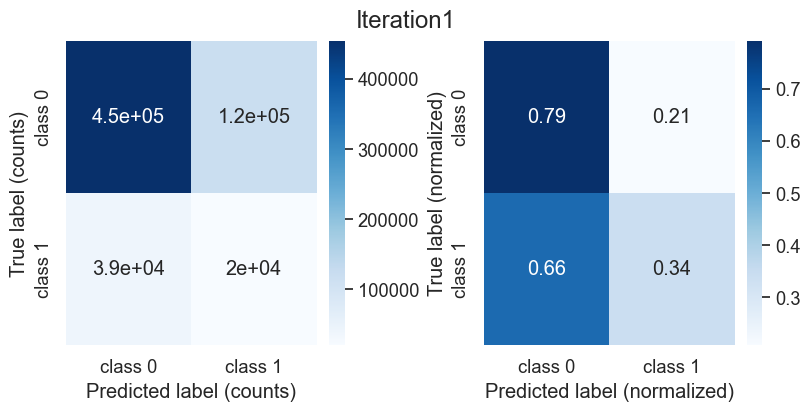

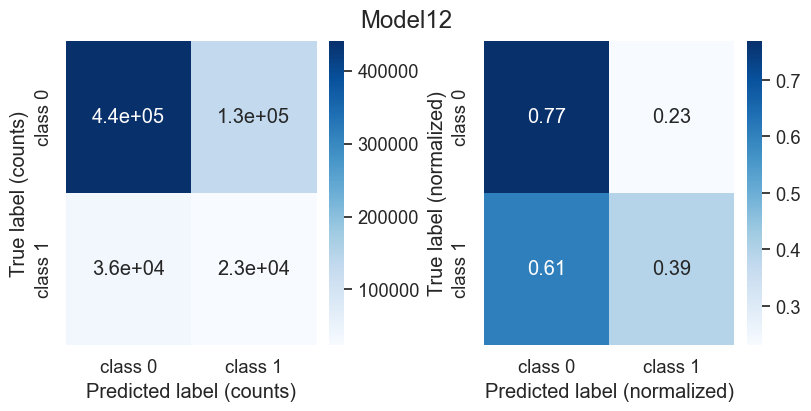

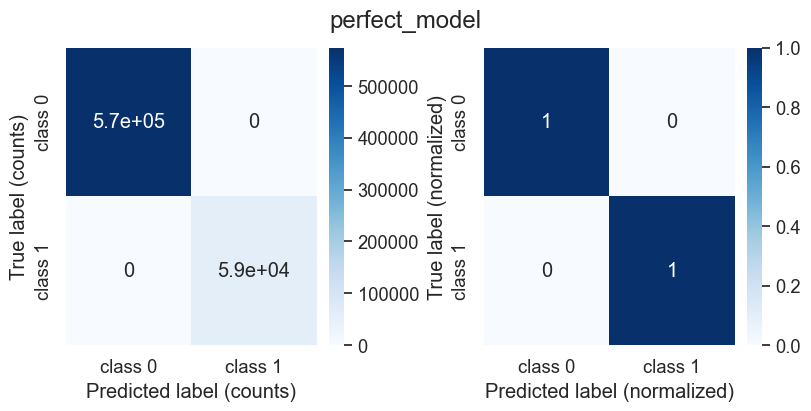

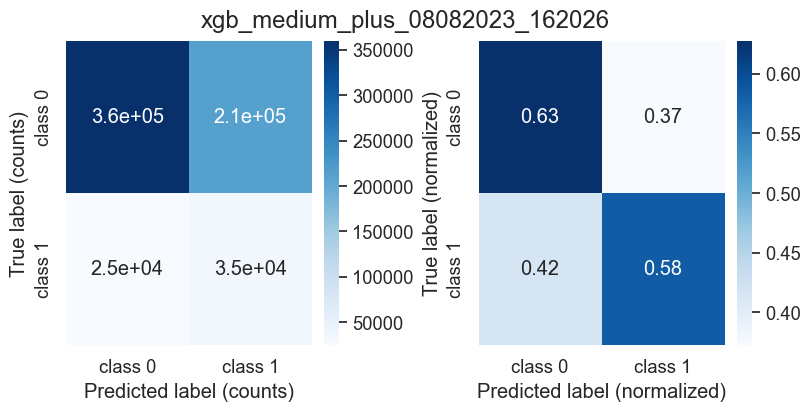

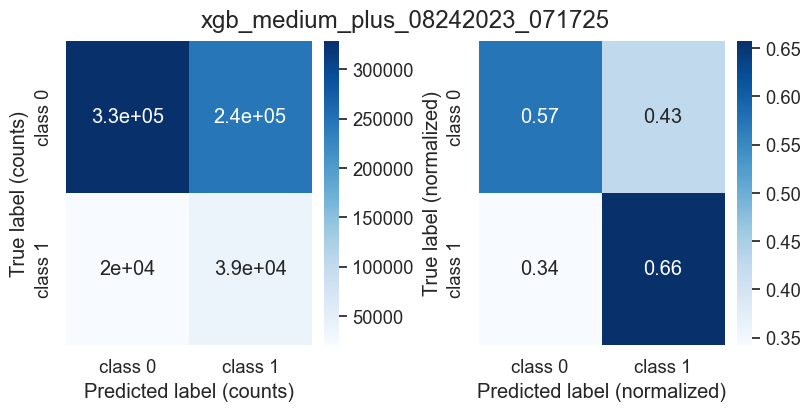

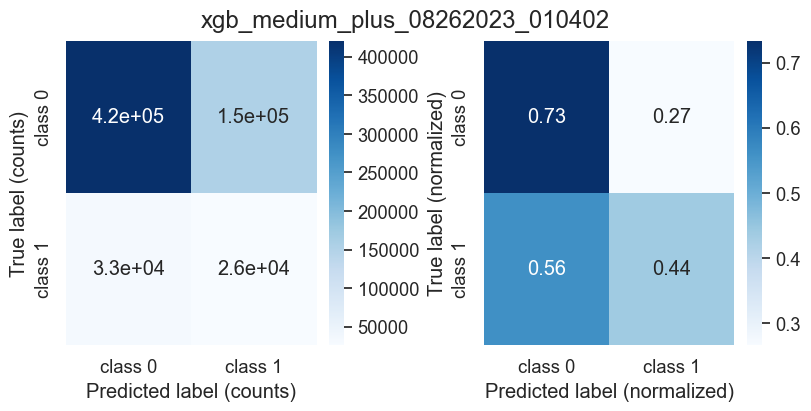

In [35]:
for name, df in scores_df.groupby('Treatment'):
    plot_confusion_matrix(
        true_labels=df.truth_label, 
        pred_labels=df.pred_label, 
        title=name,
        display_image=True, print_cm=False, save_image=False
    )

# HR and NDCG of Trained Models

## Calculate

In [36]:
COLUMNS_TO_RANKS = ['as_of_date', 'customer_id']

scores_df.head()

,as_of_date,customer_id,event_id,score,truth_label,Treatment,pred_label
0,2023-01-01,11333108,0,1.0,1,perfect_model,1
1,2023-01-01,100866063,0,0.0,0,perfect_model,0
2,2023-01-01,3262397,0,0.0,0,perfect_model,0
3,2023-01-01,118102633,0,0.0,0,perfect_model,0
4,2023-01-01,104089847,0,0.0,0,perfect_model,0


In [37]:
scores_df.Treatment.drop_duplicates().values

array(['perfect_model', 'Model12', 'Iteration1',
       'xgb_medium_plus_08082023_162026',
       'xgb_medium_plus_08242023_071725',
       'xgb_medium_plus_08262023_010402'], dtype=object)

In [38]:
exist_positive = (
    scores_df
    .groupby(['customer_id', 'as_of_date'])['truth_label']
    .transform(lambda x: sum(x==1) > 0)
)

In [39]:
at_least_n = (
    scores_df
    .groupby(['customer_id', 'as_of_date'])['event_id']
    .transform(lambda x: len(x) >= 10)

)

In [40]:
scores_df.groupby(['Treatment', 'truth_label']).count()

as_of_date  customer_id  \
Treatment                       truth_label                            
Iteration1                      0                573581       573581   
                                1                 59371        59371   
Model12                         0                573581       573581   
                                1                 59371        59371   
perfect_model                   0                573581       573581   
                                1                 59371        59371   
xgb_medium_plus_08082023_162026 0                573581       573581   
                                1                 59371        59371   
xgb_medium_plus_08242023_071725 0                573581       573581   
                                1                 59371        59371   
xgb_medium_plus_08262023_010402 0                573581       573581   
                                1                 59371        59371   

                                             event_id   score  pred_label  
Treatment                       truth_label                                
Iteration1                      0              573581  573581      573581  
                                1               59371   59371       59371  
Model12                         0              573581  573581      573581  
                                1               59371   59371       59371  
perfect_model                   0              573581  573581      573581  
                                1               59371   59371       59371  
xgb_medium_plus_08082023_162026 0              573581  573581      573581  
                                1               59371   59371       59371  
xgb_medium_plus_08242023_071725 0              573581  573581      573581  
                                1               59371   59371       59371  
xgb_medium_plus_08262023_010402 0              573581  573581      573581  
                                1               59371   59371       59371

In [41]:
scores_df.groupby(['Treatment', 'truth_label'])['score'].mean()

Treatment                        truth_label
Iteration1                       0              0.350501
                                 1              0.458709
Model12                          0              0.352514
                                 1              0.487219
perfect_model                    0              0.000000
                                 1              1.000000
xgb_medium_plus_08082023_162026  0              0.434688
                                 1              0.590981
xgb_medium_plus_08242023_071725  0              0.479939
                                 1              0.624888
xgb_medium_plus_08262023_010402  0              0.394180
                                 1              0.524530
Name: score, dtype: float64

In [42]:
scores_df[(exist_positive & at_least_n)].groupby(['Treatment', 'truth_label'])['score'].mean()

Treatment                        truth_label
Iteration1                       0              0.291227
                                 1              0.430571
Model12                          0              0.309661
                                 1              0.458599
perfect_model                    0              0.000000
                                 1              1.000000
xgb_medium_plus_08082023_162026  0              0.412481
                                 1              0.569367
xgb_medium_plus_08242023_071725  0              0.452130
                                 1              0.604410
xgb_medium_plus_08262023_010402  0              0.357852
                                 1              0.499311
Name: score, dtype: float64

In [43]:
scores_df[(exist_positive)].groupby(['Treatment', 'truth_label'])['score'].count()

Treatment                        truth_label
Iteration1                       0               1581
                                 1              59371
Model12                          0               1581
                                 1              59371
perfect_model                    0               1581
                                 1              59371
xgb_medium_plus_08082023_162026  0               1581
                                 1              59371
xgb_medium_plus_08242023_071725  0               1581
                                 1              59371
xgb_medium_plus_08262023_010402  0               1581
                                 1              59371
Name: score, dtype: int64

In [44]:
%%time
args = []
# for name, df in scores_df.groupby('Treatment'):
for name, df in scores_df[exist_positive].groupby('Treatment'):
# for name, df in scores_df[(exist_positive & at_least_n)].groupby('Treatment'):
    args.append((df, ['as_of_date', 'customer_id'], 10))

results = []

p = multiprocessing.Pool(processes=n_cpus)
results = p.starmap(func=get_hr_ndcg, iterable=args)
p.close()
p.join()

******************************
Calculating for: Iteration1
******************************
Calculating for: Model12
******************************
Calculating for: perfect_model
******************************
Calculating for: xgb_medium_plus_08082023_162026
******************************
Calculating for: xgb_medium_plus_08242023_071725
******************************
Calculating for: xgb_medium_plus_08262023_010402
CPU times: user 264 ms, sys: 129 ms, total: 392 ms
Wall time: 13.5 s


In [45]:
hr_ndcg_metrics = pd.concat(results, axis=0)
hr_ndcg_metrics.head()

,Ranks,Treatment,hit_rate,ndcg
0,1,Iteration1,0.833948,0.830258
1,2,Iteration1,1.642066,0.838143
2,3,Iteration1,2.453875,0.844627
3,4,Iteration1,3.254613,0.849374
4,5,Iteration1,4.081181,0.852266


In [46]:
hr_ndcg_metrics.Treatment.drop_duplicates()

0                         Iteration1
0                            Model12
0                      perfect_model
0    xgb_medium_plus_08082023_162026
0    xgb_medium_plus_08242023_071725
0    xgb_medium_plus_08262023_010402
Name: Treatment, dtype: object

In [47]:
hr_ndcg_metrics.groupby('Treatment')['ndcg'].mean()

Treatment
Iteration1                         0.856889
Model12                            0.870457
perfect_model                      1.000000
xgb_medium_plus_08082023_162026    0.866295
xgb_medium_plus_08242023_071725    0.853462
xgb_medium_plus_08262023_010402    0.860608
Name: ndcg, dtype: float64

# NDCG HR PLOT

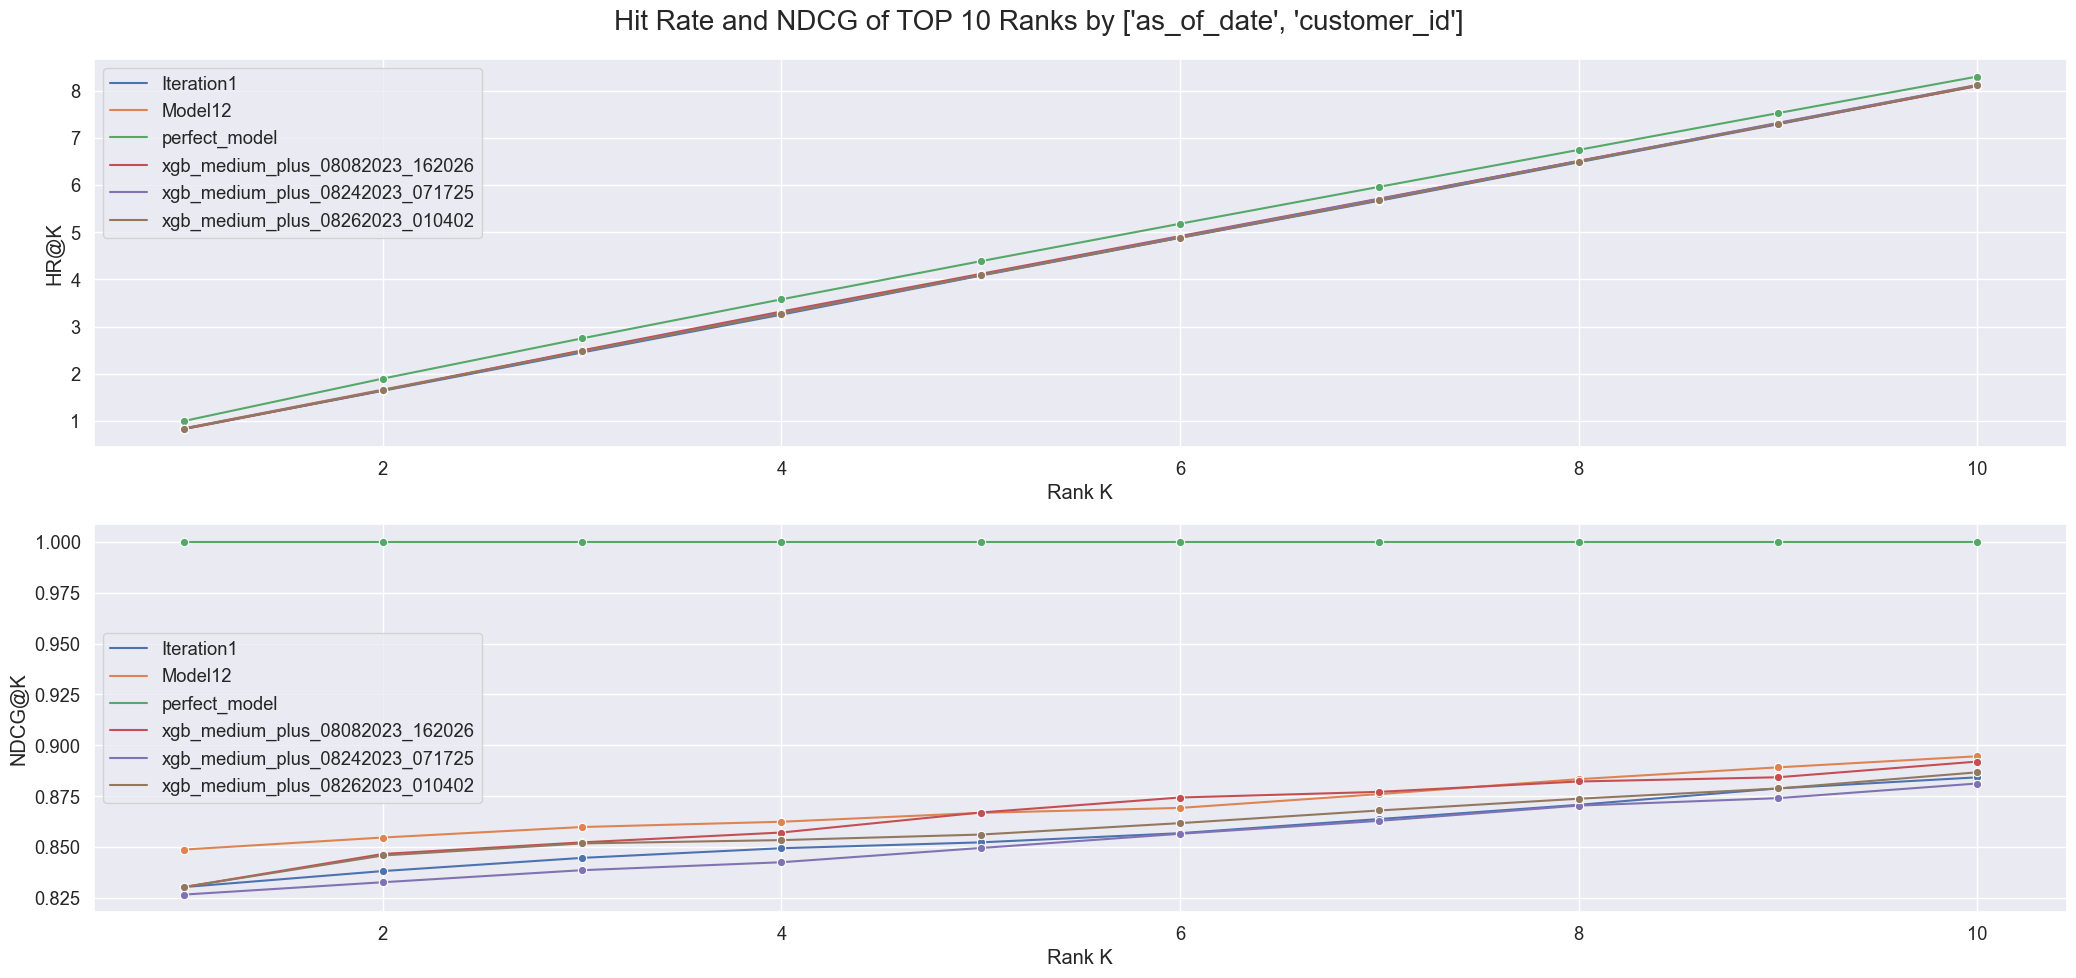

In [48]:
plot_hr_ndcg(model_metrics=hr_ndcg_metrics, cols_to_rank = COLUMNS_TO_RANKS, pdf_out=False)

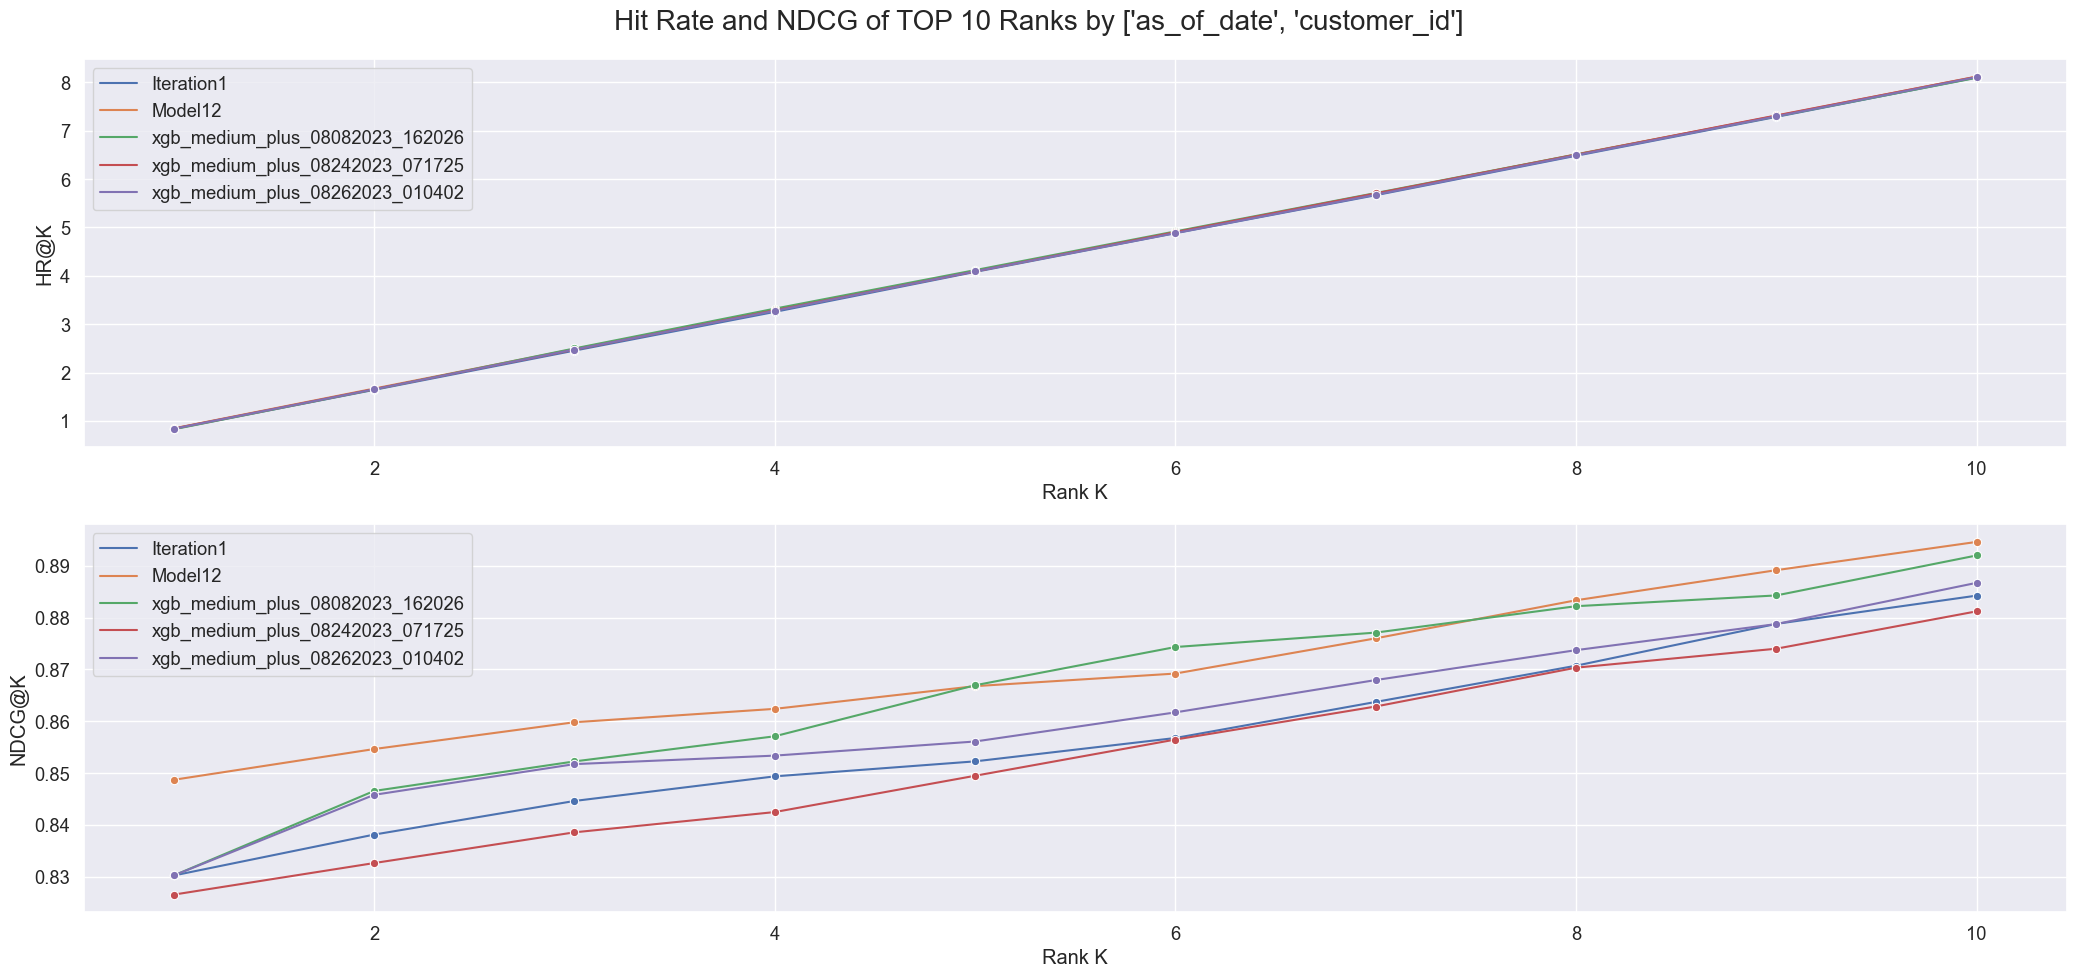

In [49]:
# plot_hr_ndcg(model_metrics=hr_ndcg_metrics[hr_ndcg_metrics.Treatment.isin(["perfect_2022", "Champion_2022", "xgb_700f2_2_medium"])], pdf_out=True)

plot_hr_ndcg(
    model_metrics=hr_ndcg_metrics[hr_ndcg_metrics.Treatment.isin(
        [
            # "perfect_model",
            "Model12",
            "Iteration1", 
            "xgb_medium_plus_08082023_162026", 
            "xgb_medium_plus_08242023_071725",
            "xgb_medium_plus_08262023_010402"
        ])], cols_to_rank = COLUMNS_TO_RANKS,
    pdf_out=False)